# Sign Language Detection
Soen 479 Final project

1. <a href="#Install-Dependencies">Install Dependencies</a>
2. <a href="#Importing-the-dependencies">Importing the dependencies</a>
3. <a href="#Make-sure-that-we-can-access-the-webcam">Access webcam</a>
4. <a href="#Making-sure-the-video-and-landmarks-are-functional">Check video landmarks</a>
5. <a href="#Extract-the-x,-y,-and-z-values">Extract values</a>
6. <a href="#Setup-folder-management">Folder management</a>
7. <a href="#This-is-where-we-start-collecting-the-data">Data collection</a>
8. <a href="#Preprocessing">Data Preprocessing</a>
9. <a href="#Training-the-nural-network-(Mediapipe-hollistics-+-LSTM-layers)">Training Neural Network</a>
10. <a href="#This-is-where-we-make-the-predictions">Predictions</a>
11. <a href="#Save-the-models-after-having-ran-them">Saving Models</a>
12. <a href="#Confusion-matrix-to-evaluate-true-positive,-true-negative,-false-positive,-false-negative">Confusion Matrix</a>
13. <a href="#Evalutating-witht-the-training-data-is-not-ideal-but-we-do-not-have-any-other-options-at-the-moment">Importing the Evaluation</a>
14. <a href="#Real-time-testing">Real Time Testing</a>


# Install Dependencies
using https://www.geeksforgeeks.org/python-facial-and-hand-recognition-using-mediapipe-holistic/ as a reference<br>
**Does not work with Python 3.9 (because of tensorflow)**

In [1]:
from platform import python_version

In [2]:
#Use python 3.8 for the dependencies to work
print(python_version())

3.8.0


In [3]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1

In [4]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Importing the dependencies

In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Make sure that we can access the webcam 

In [9]:
#make detections
mediapipe_holistic = mp.solutions.holistic
#draw the detections
mediapipe_drawing = mp.solutions.drawing_utils

In [10]:
def mediapipe_detection(image, model):
    # 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # use this to save memory
    image.flags.writeable = False
    # detect using mediapipe
    results = model.process(image)
    # setting writable back on
    image.flags.writeable = True 
    # switch from RGB color space to BGR color space since opencv uses BGR image format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    return image, results

In [11]:
def draw_better_landmarks(image, results):
#using https://www.geeksforgeeks.org/python-facial-and-hand-recognition-using-mediapipe-holistic/ configuration for better vosualization

    #only drawing the hands since the face and pose seem irrelevant for our project (for now)
    #for the left hand
    mediapipe_drawing.draw_landmarks(image, results.left_hand_landmarks, mediapipe_holistic.HAND_CONNECTIONS, 
                             mediapipe_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mediapipe_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    #for the right 
    mediapipe_drawing.draw_landmarks(image, results.right_hand_landmarks, mediapipe_holistic.HAND_CONNECTIONS, 
                             mediapipe_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mediapipe_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Making sure the video and landmarks are functional

In [12]:
#access webcam (device 0 on my laptop is my webcam)
#might have to change the device if running on another machine
capture = cv2.VideoCapture(0)
#set the model, try to play with the confidence values. I think a higher tracking confidence might be better since we are using it for action recognition
with mediapipe_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.6) as holistic:
    #while the webcam is opened, loop through all the fames
    while capture.isOpened():
        #read the current frame
        ret, frame = capture.read()
        #call the mediapipe_detection function on the frame
        image, results = mediapipe_detection(frame, holistic)
        
        #draw the landmarks on the frame
        draw_better_landmarks(image, results)
        
        #show the frame to the screen and name it
        cv2.imshow('Hand Sign Recognition', image)

        #once we press q, we break out of the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    #release the resources
    capture.release()
    cv2.destroyAllWindows()


These are the points being tracked in real time. It tracks both hands

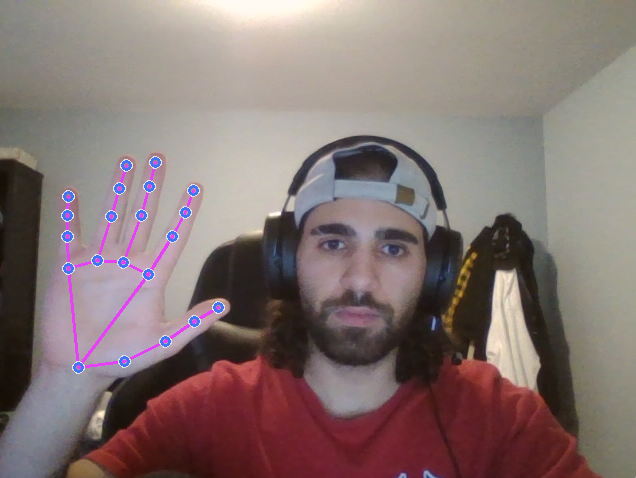

# Extract the x, y, and z values

In [13]:
# pose = []
# #put all the landmarks in one flattened array
# for res in results.pose_landmarks.landmark:
#     all_landmarks = np.array([res.x, res.y, res.z, res.visibility])
#     pose.append(all_landmarks)

In [14]:
#use list comprehension and flattening to make the array more readable and add error handling for when hand is not in frame
left_hand = np.array([[result.x, result.y, result.z] for result in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
right_hand = np.array([[result.x, result.y, result.z] for result in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)

In [15]:
def extract_keypoints(results):
    #left hand and right hand do not have any visibility. Adapted the arrays lengths.
    #if a hand is not is the frame, just put zeros everywehre (63 points of data per hand)
    #DONT NEED FACE
    left_hand = np.array([[result.x, result.y, result.z] for result in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    right_hand = np.array([[result.x, result.y, result.z] for result in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    #concatenate all the results together
    return np.concatenate([left_hand, right_hand])

# Setup folder management

In [16]:
print(os.getcwd())

C:\Users\anthc\Desktop\Python


In [17]:
# Store the path
DATA_PATH = os.path.join(os.getcwd(), 'Data')

# Create folder Data if it does not already exists
if not os.path.exists('Data'):
    os.makedirs('Data')

# will be adding more words as well as individual letters.
actions = np.array(['Hello', 'ThankYou', 'Eat', 'Sorry', 'Family'])

# We will be using 30 frames to try and classify a specific action
#we are using 30 video sequences of 30 frames each
video_sequences = 30
sequence_length = 30

# Folders start at index 1
start_folder = 1

In [18]:
#loop through all the actions, loop through all the sequences and create the folders
for action in actions: 
    for sequence in range(1,video_sequences+1):
        try:
            if not os.path.exists(os.path.join(DATA_PATH, action, str(sequence))):
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            print('Error occured')

# This is where we start collecting the data
## The signs that only require one hand will be signed with the right hand and the left hand will be out of the frame

In [19]:
# used similar function to when we were testing the motion recognition but modified the loops

#access webcam (device 0 on my laptop is my webcam)
capture = cv2.VideoCapture(0)
#set the model, try to play with the confidence values. I think a higher tracking confidence might be better
with mediapipe_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.6) as holistic:
    
    #start by looping by all the actions we have (dictionary of ASL words/letters)
    for action in actions:
        # then loop through every set of frames stored for that action
        for sequence in range(start_folder, start_folder+video_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                #read the current frame
                ret, frame = capture.read()

                #call the mediapipe_detection function on the frame
                image, results = mediapipe_detection(frame, holistic)

                #draw the landmarks on the frame
                draw_better_landmarks(image, results)
                
                #for each video, if we are at frame zero, take a small (300ms) break to prepare
                if frame_num == 0: 
                    cv2.putText(image, 'START', (100,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action}, Video Number {sequence}', (15,12),
                               cv2.FONT_HERSHEY_PLAIN, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    #show the frame to the screen and name it
                    cv2.imshow('Hand Sign Recognition', image)
                    cv2.waitKey(300)
                #if we are not at frame zero, we will just output what frame we are collecting data for and show it
                else:
                    cv2.putText(image, f'Collecting frames for {action}, Video Number {sequence}', (15,12), 
                               cv2.FONT_HERSHEY_PLAIN, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    #show the frame to the screen and name it
                    cv2.imshow('Hand Sign Recognition', image)
                
                # we will then save the keypoints here that we are collecting
                keypoints = extract_keypoints(results)
                numpy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(numpy_path, keypoints)

                #once we press q, we break out of the loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    #release the resources                
    capture.release()
    cv2.destroyAllWindows()

# Preprocessing

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
# format all the actions in an enumeration format
label_map = {label:num for num, label in enumerate(actions)}

In [22]:
label_map

{'Hello': 0, 'ThankYou': 1, 'Eat': 2, 'Sorry': 3, 'Family': 4}

In [23]:
# loop through each actions and appending all the data to the sequences, and then appending the labels to label
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [24]:
X = np.array(sequences)

In [25]:
# works like a binary flag to detect the different labels
y = to_categorical(labels).astype(int)

In [26]:
# use the train_test_split from sklearn to perform a training and testing partition.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Training the nural network (Mediapipe hollistics + LSTM layers)
## CNN layers + LSTM layers would also be possible but it uses more datapoints

In [27]:
# build sequencial nural network
from tensorflow.keras.models import Sequential
# LSTM layer and perform action detection
from tensorflow.keras.layers import LSTM, Dense
# logging to be able to trace
from tensorflow.keras.callbacks import TensorBoard

In [28]:
log_dir = os.path.join(os.getcwd(), 'Logs')
if not os.path.exists('Logs'):
    os.makedirs('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [29]:
X.shape

(150, 30, 126)

In [30]:
# neural network setup 

# instantiating the sequencial API
model = Sequential()
# 3 sets of LSTM layers need to return the sequences since the next layers need them, can play around with activation function
# input shape found with X.shape
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
# next layer is a dense layer, so we set return sequence to false
model.add(LSTM(64, return_sequences=False, activation='relu'))

# sets of dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# return values within 0 and 1, we the sum of all the values adding up to 1.
model.add(Dense(actions.shape[0], activation='softmax'))

In [31]:
# compile the model (look at different optimizers), we need this loss function we use when we have a multi class classification
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
#user tensorboard for more data about the nural network
model.fit(X_train, y_train, epochs=10, callbacks=[tb_callback])

Epoch 1/10
5/5 [==============================] - 0s 76ms/step - loss: 0.0096 - categorical_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0072 - categorical_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0056 - categorical_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 0s 40ms/step - loss: 0.0025 - categorical_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 42ms/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 0s 40ms/step - loss: 0.0197 - categorical_accuracy: 0.9930
Epoch 8/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0030 - categorical_accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 0s 39ms/step - loss: 0.0070 - categorical_accuracy: 1.0000
Epoch 10/10
5/5 [==

## Tensorboard data on the categorical accurancy as well as the epoch loss

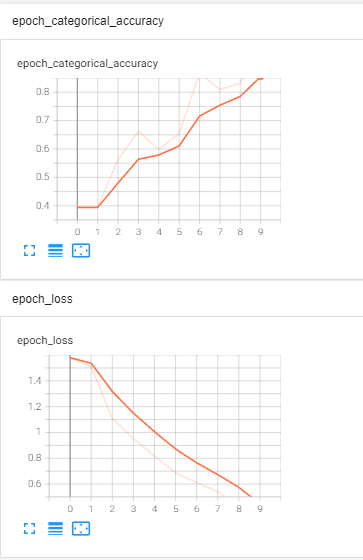

In [36]:
# not using CNN since it uses multiple millions of params instead of 600K
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            48896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 203,525
Trainable params: 203,525
Non-trainable params: 0
__________________________________________________

# This is where we make the predictions

In [37]:
res = model.predict(X_test)

In [38]:
res

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00],
       [9.99959826e-01, 8.41006653e-10, 3.79925732e-05, 2.05750939e-06,
        1.16252998e-07],
       [1.14674993e-04, 1.25233805e-06, 9.99567688e-01, 3.15903628e-04,
        4.22881186e-07],
       [1.71772714e-19, 3.41578953e-15, 1.76246189e-07, 9.99999881e-01,
        4.22890227e-33],
       [6.16319426e-07, 9.99997139e-01, 5.20066870e-08, 2.28090289e-06,
        2.44761722e-09],
       [9.99985218e-01, 9.49960249e-11, 1.42633889e-05, 5.04641889e-07,
        2.06885975e-08],
       [4.87035468e-10, 1.00000000e+00, 3.04898901e-13, 1.10884493e-08,
        6.20983435e-14],
       [9.99989867e-01, 5.25545718e-11, 9.80240929e-06, 3.36097230e-07,
        1.35497435e-08]], dtype=float32)

# Save the models after having ran them

In [39]:
model.save('action.h5')

# Confusion matrix to evaluate true positive, true negative, false positive, false negative

In [40]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [41]:
yhat = model.predict(X_train)

In [42]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

# Evalutating witht the training data is not ideal but we do not have any other options at the moment

In [43]:
# true positive, false positive
# false negative, true negative
multilabel_confusion_matrix(ytrue, yhat)

array([[[115,   0],
        [  0,  27]],

       [[114,   0],
        [  0,  28]],

       [[113,   0],
        [  0,  29]],

       [[113,   0],
        [  0,  29]],

       [[113,   0],
        [  0,  29]]], dtype=int64)

In [44]:
accuracy_score(ytrue, yhat)

1.0

# Real time testing

In [45]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [47]:
# Re-using the same function we were using for the function detection
# Adding detection variables

# collect the frames to generate a prediction (predict once it hits 30 frames)
sequence = []
# concatenate history of detection
sentence = []
# only render results if it is over the threshold
threshold = 0.85
predictions = []
text = ''


#access webcam (device 0 on my laptop is my webcam)
capture = cv2.VideoCapture(0)
#set the model, try to play with the confidence values. I think a higher tracking confidence might be better
with mediapipe_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.6) as holistic:
    #while the webcam is opened, loop through all the fames
    while capture.isOpened():
        #read the current frame
        ret, frame = capture.read()
        #call the mediapipe_detection function on the frame
        image, results = mediapipe_detection(frame, holistic)
        
        #draw the landmarks on the frame
        draw_better_landmarks(image, results)
        
        # adding the prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        # grabbing last 30 frames to generate the prediction
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            # we use np.expand_dims to adjust the shape that our sequence is expecting
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
        #3. visualization logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                # we first start by extracting the highest score result and making sure it is over the threshold
                if res[np.argmax(res)] > threshold: 
                    # we check if we have words in our sentence in order to not have doubles
                    if len(sentence) > 0:
                        # if the last word matches the current prediction, we are NOT going to append
                        # otherwise, we are going to append it
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
            
            if len(sentence) > 5:
                sentence = sentence[-5:]
            
            pct = res[np.argmax(res)] * 100
            text = f'{actions[np.argmax(res)]} :  {pct:.2f}  %'
            
#             image = cv2.putText(image, text, (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)             
            # adding the probabilities to the visualization
#             image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, text, (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        
        #show the frame to the screen and name it
        cv2.imshow('Hand Sign Recognition', image)

        #once we press q, we break out of the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    #release the resources
    capture.release()
    cv2.destroyAllWindows()

<a href="#Sign-Language-Detection">[Back to top]</a>

In [50]:
%%HTML
<video width=400 controls>
    <source src="HandRecognitionVid.mp4" type="video/mp4">
</video>